# Numerical Analysis Project
### Plasencia Palacios Milton Nicolas
### DSSC, A.A 2019-2020

In [3]:
%pylab inline
import sympy as sym
import scipy
from scipy.interpolate import *
from scipy.integrate import *
import matplotlib.pyplot as plt
import math 

Populating the interactive namespace from numpy and matplotlib


## Problem Statement and Data

The target of this final project is to implement a python code able to solve the Allen Cahn equation:

\begin{equation}
\frac{\partial \eta}{\partial t} - \epsilon^2 \eta '' + \textit{f } ' (\eta) =0
\end{equation}

This equation describes the time evolution of a scalar-valued state variable $\eta$ on a domain $\Omega = [0,1]$ during a interval interval $[0,T]$ where f is a double-well potential which can be defined as it follows:

\begin{equation}
\textit{f}(\eta)= \eta ^2 (\eta -1)^2 .
\end{equation}

Using finite difference by time we can dicretize the problem, obtaining the equation:

\begin{equation}
((v_i , v_j) + \Delta t \epsilon ^2 (v_i ' , v_j '))\eta_{k+1}^j =((v_i, v_j)\eta_k^j -\Delta t(v_i , \textit{f }'(\eta_k) ))
\end{equation}

in which $\{ v_i \}_{i=0}^n$ is the set of basis function and $ \eta= \eta ^j v_j$. The problem to solve now can be written in the following way:

\begin{equation}
Ax=b
\end{equation}

where:

\begin{equation}
A_{ij} =M_{ij} + \Delta t \epsilon ^2 K_{ij} = ((v_i , v_j) + \Delta t \epsilon ^2 (v_i ' , v_j '))
\end{equation}

and:

\begin{equation}
b_i = M_{ij}(\eta_k^j - \Delta t \textit{f }' (\eta_k^j)).
\end{equation}

Solve the equation using the following data. 

In [4]:
eps =[0.01, 0.001]                                  # error epsilon
ndofs = [16, 32, 64, 128]                           # degrees of freedom
degree = [1, 2, 3]                                  # degree
dt = [ 0.25, 0.125, 0.0625, 0.03125, 0.015625]      # timestep

def f(eta):                                         # double potential function
    return eta**2 *(eta-1)**2    

def eta0(x):                                        # eta_0 function
    return (np.sin(2*pi*x)+1)

# Step 1

In [5]:
# Step 1.1 compute the derivative of the double well potential
def F(eta):                                     
    return 4*eta**3 - 6*eta**2 + 2*eta

In [6]:
# Step 1.2 return list of basis functions
def compute_basis_functions(support_points, degree):
    basis = []
    dbasis = []
    for i in range(len(support_points)):
        c = support_points*0 
        c[i] = 1
        bi = PPoly.from_spline(splrep(support_points,c,k=degree))
        
        basis.append(bi)
        dbasis.append(bi.derivative(1))
    return basis, dbasis                                          #return also dbasis, useful later

In [7]:
# Step 1.3 compute global quadrature points and global quadrature weights
def compute_global_quadrature(basis, n_gauss_quadrature_points):
    intervals = unique(basis[0].x)
    qp, w = numpy.polynomial.legendre.leggauss(n_gauss_quadrature_points)
    qp = (qp+1)/2
    w /= 2
    
    h = diff(intervals)
    global_quadratures = array([intervals[i]+h[i]*qp for i in range(len(h))]).reshape((-1,))
    global_weights = array([w*h[i] for i in range(len(h))]).reshape((-1,))
    return global_quadratures, global_weights

In [8]:
# Step 1.4 return the matrices M and K
def compute_system_matrices(basis, dbasis, global_quadrature, global_weights):
    Bq = array([basis[i](global_quadrature) for i in range(len(basis))]).T
    dBq = array([dbasis[i](global_quadrature) for i in range(len(basis))]).T
    
    M1 = einsum('qi, q, qj', Bq, global_weights, Bq)
    K = einsum('qi, q, qj', dBq, global_weights, dBq)
    return M1, K

# Step 2

Solve the Allen-Cahan equation on the interval $[0,1]$, from time $t=0$ and time $t=1$, given a time step dt, a number of degrees of freedom ndofs, and a polynomial degree k.

In [9]:
#Step 2.1 compute eta matrix and the set of basis functions
def solve_allen_cahn(eta_0_function, eps, dt, ndofs, degree):
    k = 1/dt + 1                                             # +1 to calculate in T=1
    eta = zeros((int(k), ndofs))                             # result matrix 
    q = linspace(0,1, ndofs)                                 # points for the computation
    
    b, db = compute_basis_functions(q, degree)
    gq, gw = compute_global_quadrature(b, degree+1)
    M, K = compute_system_matrices(b, db, gq, gw)
    
    eta_zero = eta_0_function(q)
    eta[0,:] = eta_zero                                      # fill the first row with eta zero
    
    lhs = M + (dt*eps**2)*K                                  # left hand side of Ax = b
    
    eta_prev = eta_zero
    for i in range (1, int(k)):
        rhs = M.dot(eta_prev - dt*F(eta_prev))               # right hand side of Ax = b
        eta_next = linalg.solve(lhs, rhs)
        eta[i,:] = eta_next                                  # fill the matrix with the new value of eta
        eta_prev = eta_next                                  # refreshing eta's value
    return eta, b

In [10]:
#Step 2.2 plot the solution eta_0, eta_s and eta_{2s}
def plot_solution(eta, basis, stride, resolution):
    x = linspace(0,1, resolution)
    
    B=zeros((resolution, len(basis)))
    
    for i in range(len(basis)):
        B[:,i] = basis[i](x)
    for i in range(3):
        if (i*stride)> (len(eta)-1):
            break
        y = eta[i*stride,:].dot(B.T)
        _=plot(x,y, label='t= ' + str(i*stride/(len(eta)-1)))
    
    plt.title('solution')    
    plt.xlabel('x')
    plt.ylabel('eta')
    plt.legend()

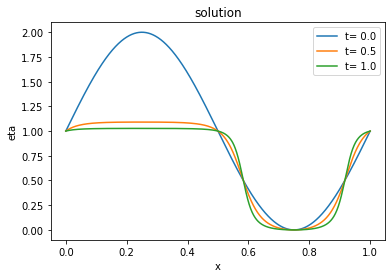

In [23]:
#Debug solve_allen_cahn and plot_solution
error= 0.001
step=0.03125
grad=64
deg=3

eta, bas = solve_allen_cahn(eta0, error, step, grad, deg)
stri=16
reso=1025

plot_solution(eta, bas, stri, reso)

# Step 3

Solve the equation with the data we have and the previous functions and plot the final solution at $t =1$ and with:

\begin{equation}
\eta_0 = \sin (2 \pi x) +1 .
\end{equation}

In [12]:
# This function will plot the solution at t=1 and t=0 for every 'ndofs'
def plot_solution_at_one(eps, dt, ndofs_list, degree, res):
    x = linspace(0,1, res)

    y = eta0(x)
    '''_ = plot(x,y, label='t= 0')                                       # all in the same plot
                                                                         # it is not that clear
    for j in range(len(ndofs_list)):        
        eta, b = solve_allen_cahn(eta0, eps, dt, ndofs_list[j], degree)
        B=zeros((resolution, len(b)))
        for i in range(len(b)):
            B[:,i] = b[i](x)
        _ = plot(x, eta[-1].dot(B.T), label='ndofs= '+str(ndofs_list[j])) 
    
    plt.title('solution for: eps= ' +str(eps)+ ' dt= ' +str(dt)+ ' degree= ' +str(degree))    
    plt.xlabel('x')
    plt.ylabel('eta')
    plt.legend()'''
    
    fig, axs =plt.subplots(1,4, figsize=(20,5))                        # 4 plots per row
    fig.suptitle('Solution at eps= ' +str(eps)+ ', dt= ' +str(dt)+', degree= '+str(degree)+ ' and resolution= ' +str(res))
    for j in range(len(ndofs_list)):        
        eta, b = solve_allen_cahn(eta0, eps, dt, ndofs_list[j], degree)
        B=zeros((resolution, len(b)))
        for i in range(len(b)):
            B[:,i] = b[i](x)
        (axs[j]).plot(x, eta[-1].dot(B.T))
        (axs[j]).plot(x,y)
        (axs[j]).set_title('solution at ndofs=' +str(ndofs[j]))
        (axs[j]).set(xlabel='x', ylabel='eta')

        (axs[j]).legend( ['t= 1', 't= 0'])

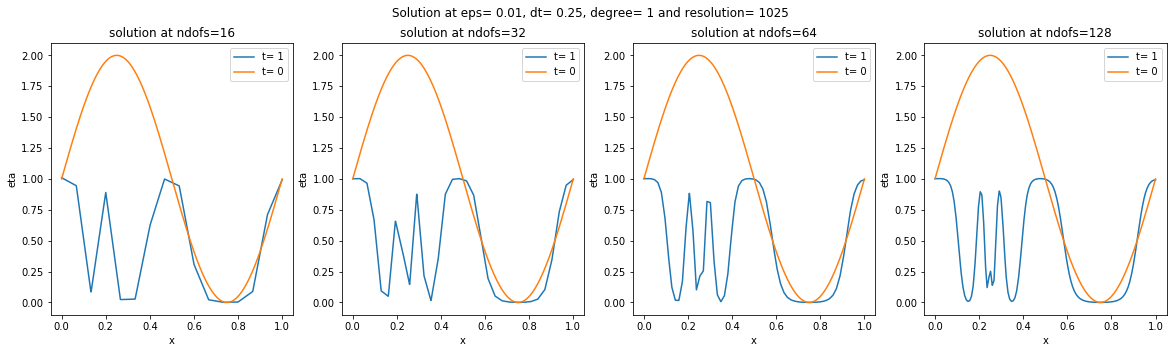

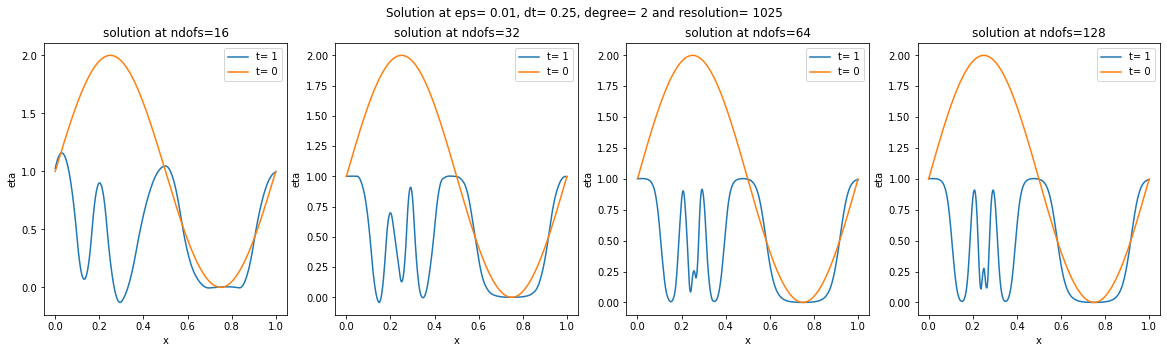

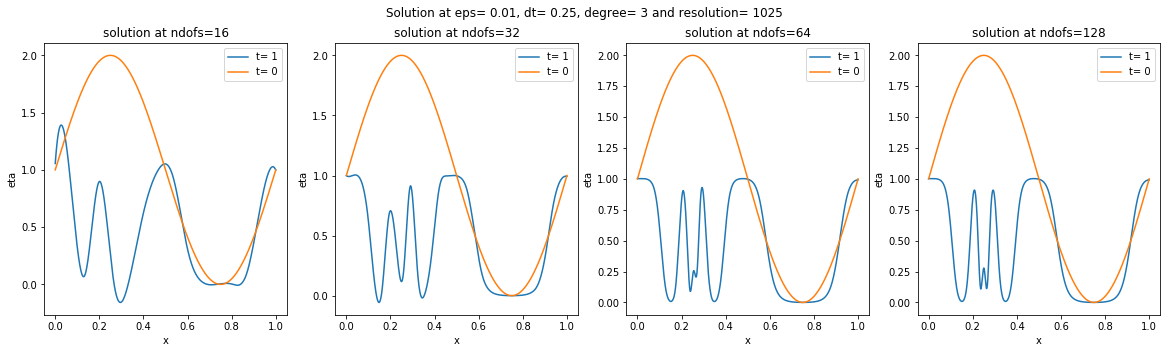

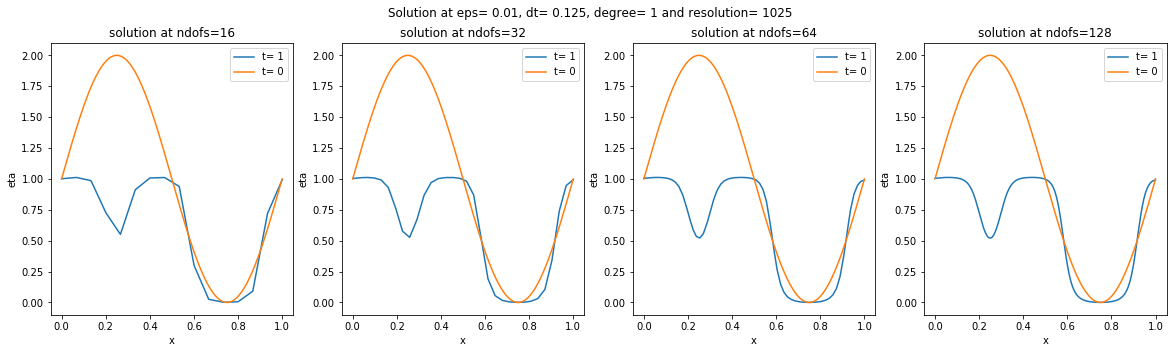

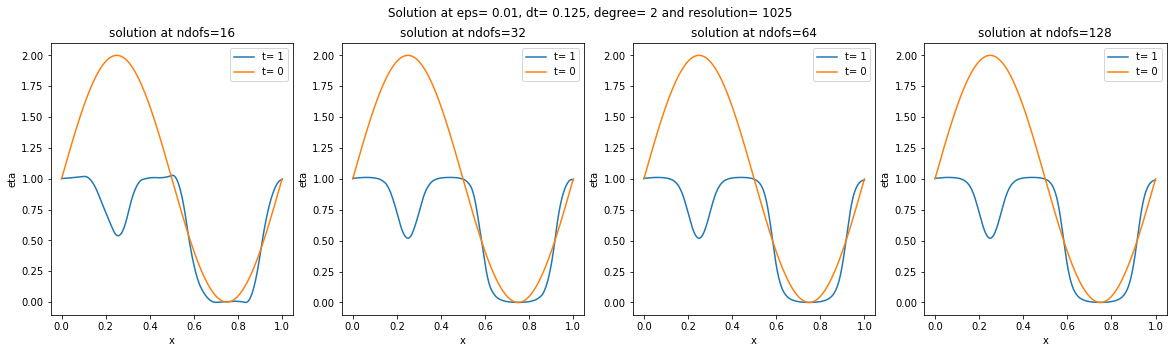

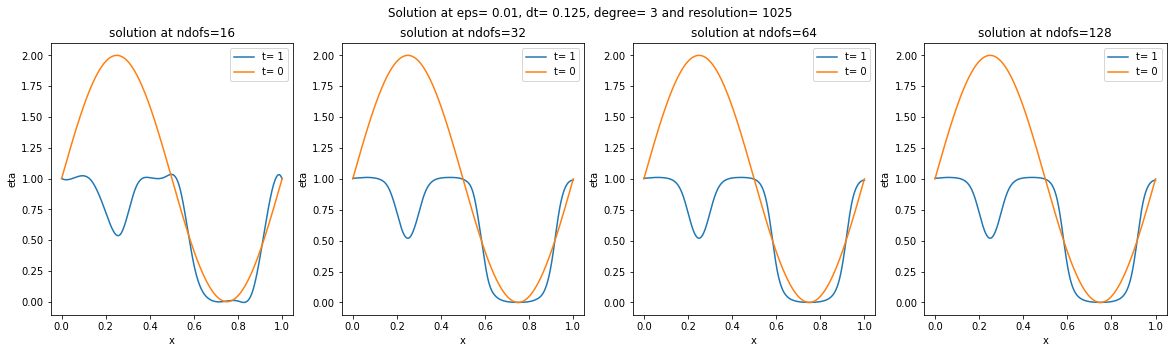

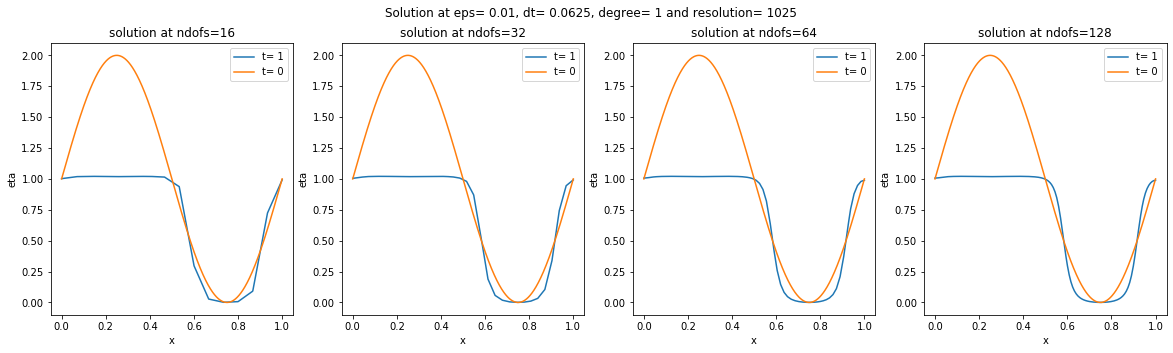

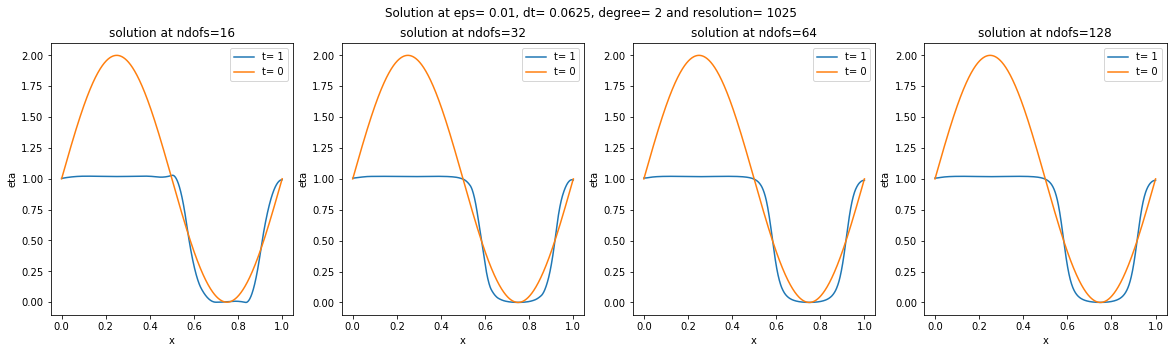

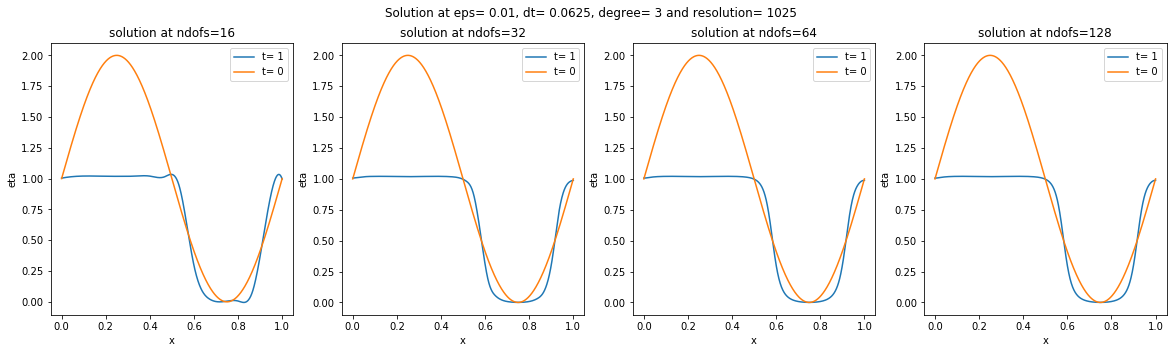

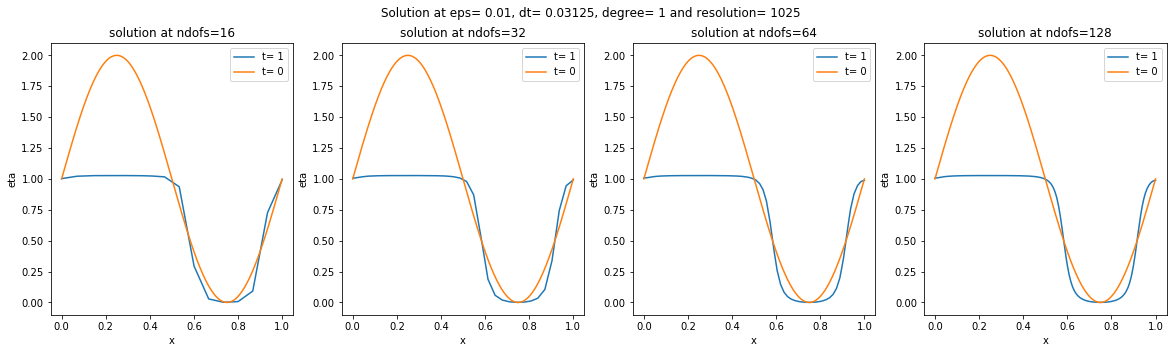

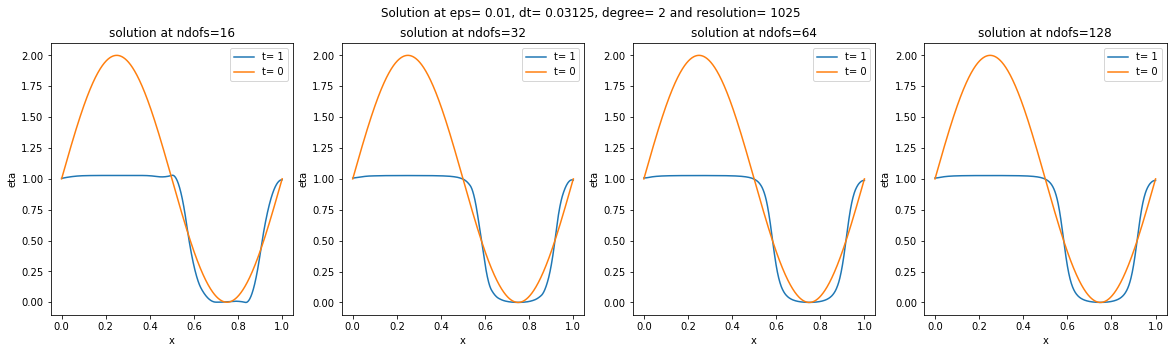

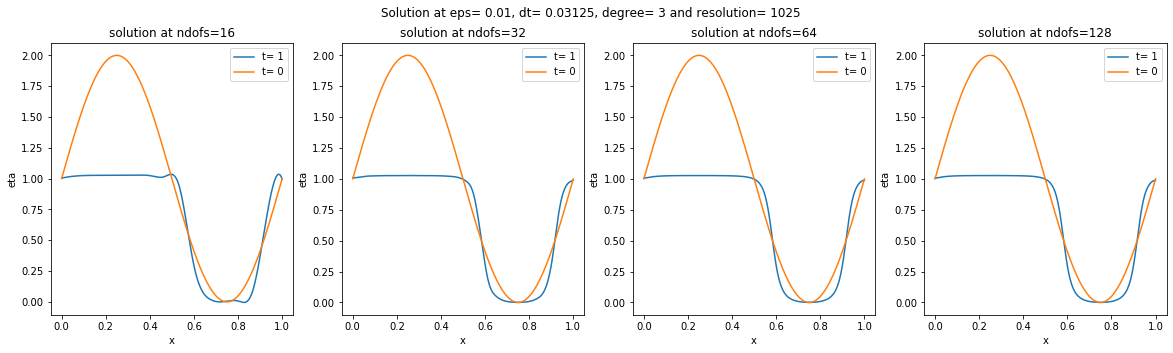

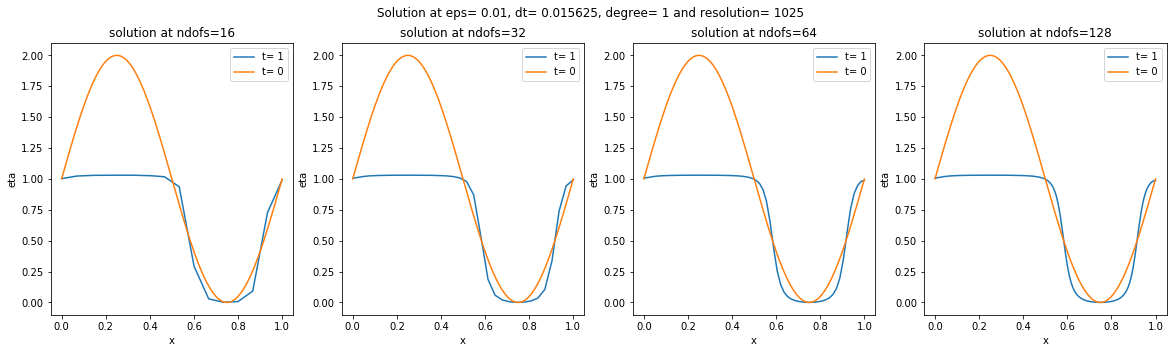

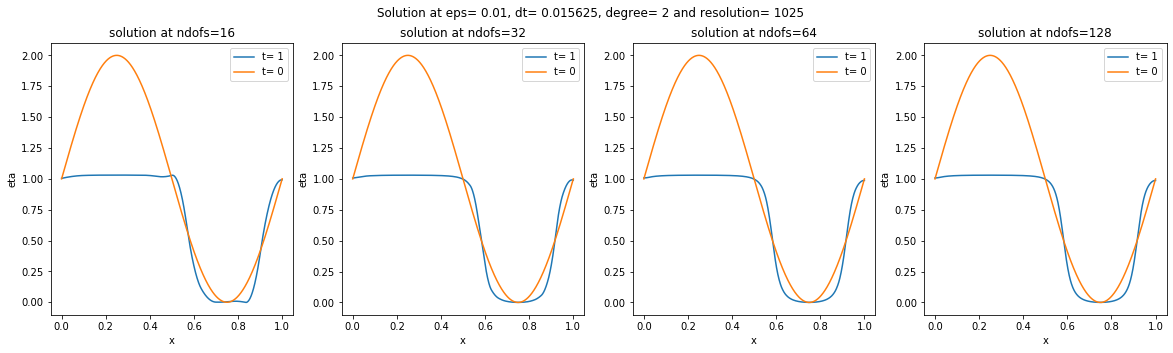

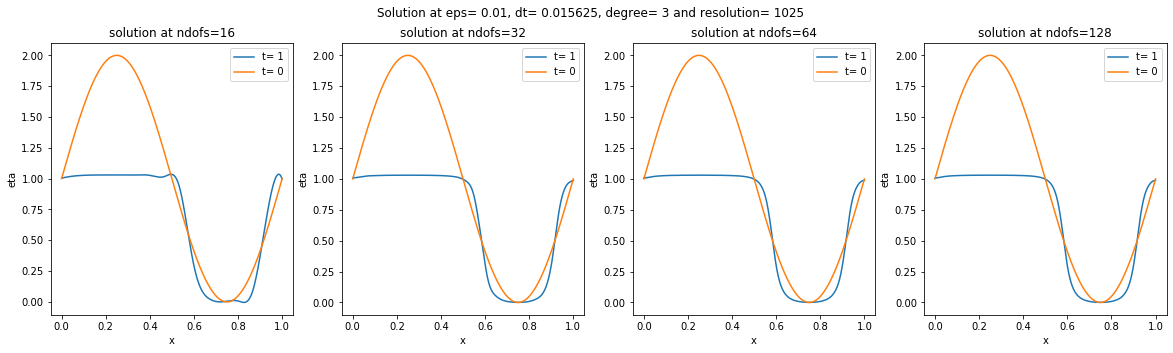

In [14]:
# Plots with eps = 0.01
resolution = 1025
#for i in range(len(eps))
for j in range(len(dt)):
    for k in range(len(degree)):
        plot_solution_at_one(eps[0], dt[j], ndofs, degree[k], resolution)


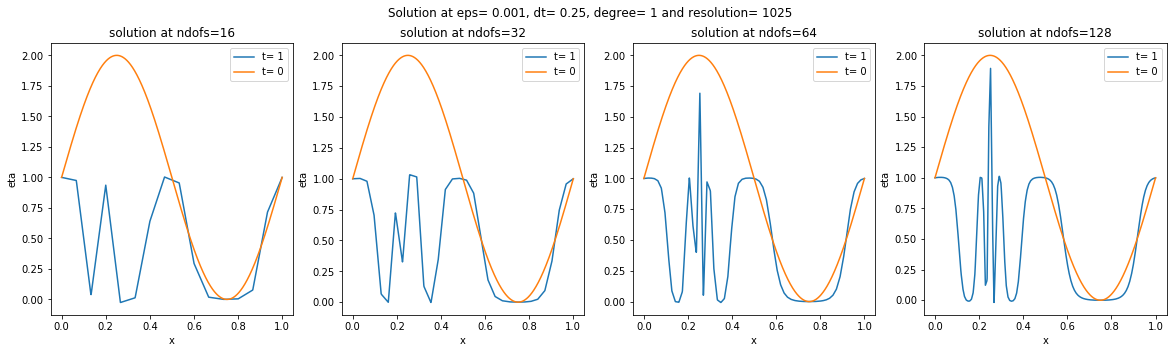

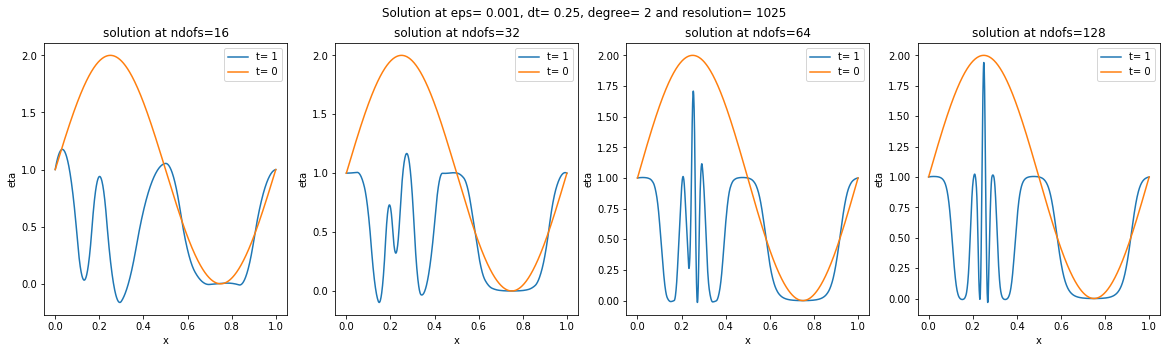

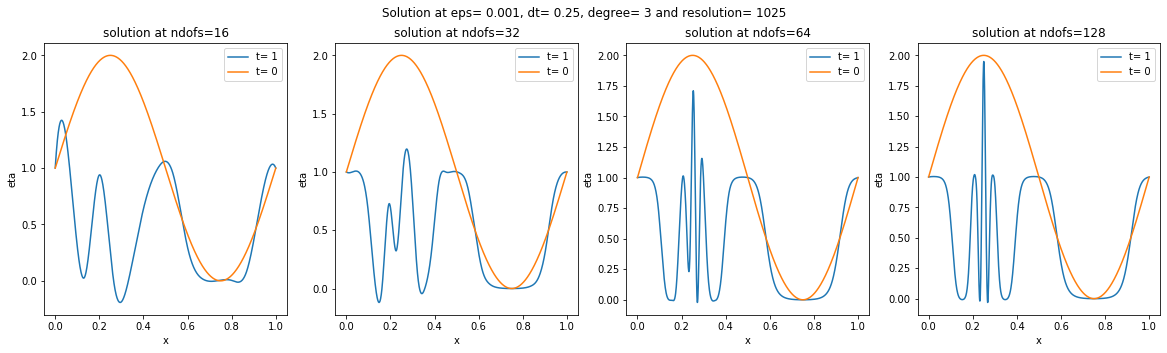

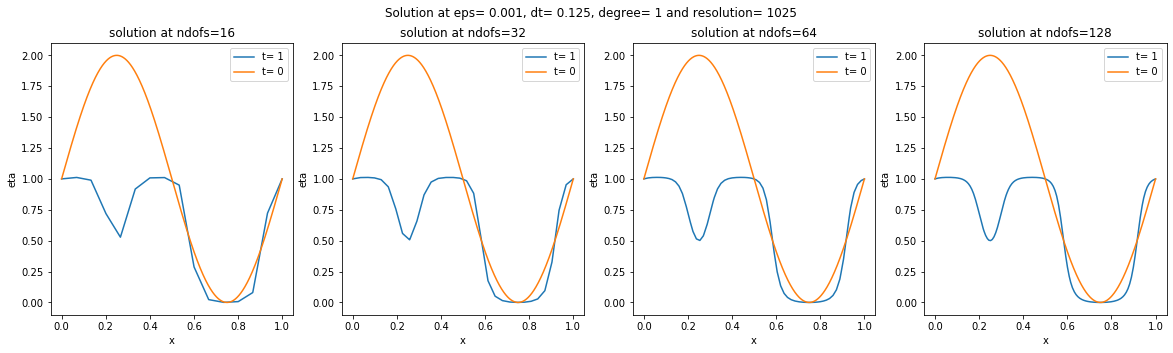

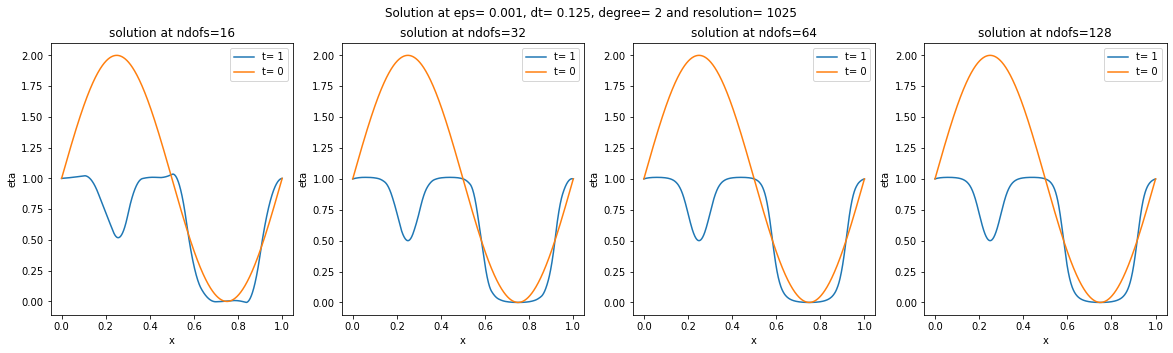

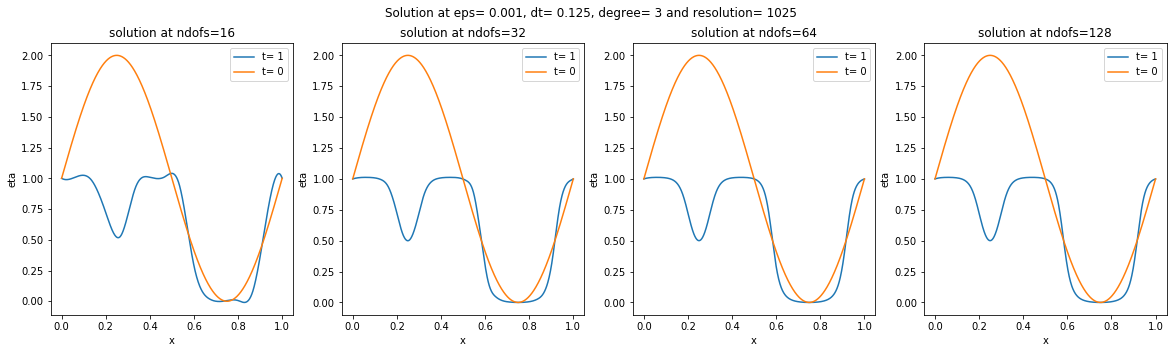

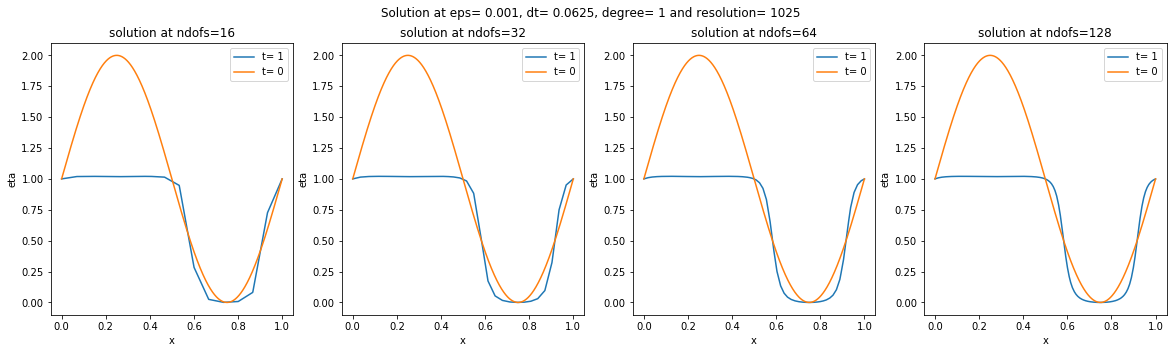

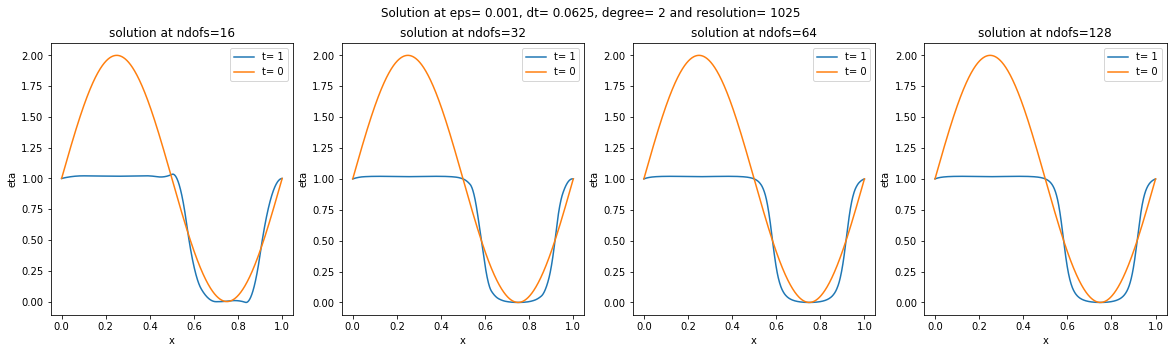

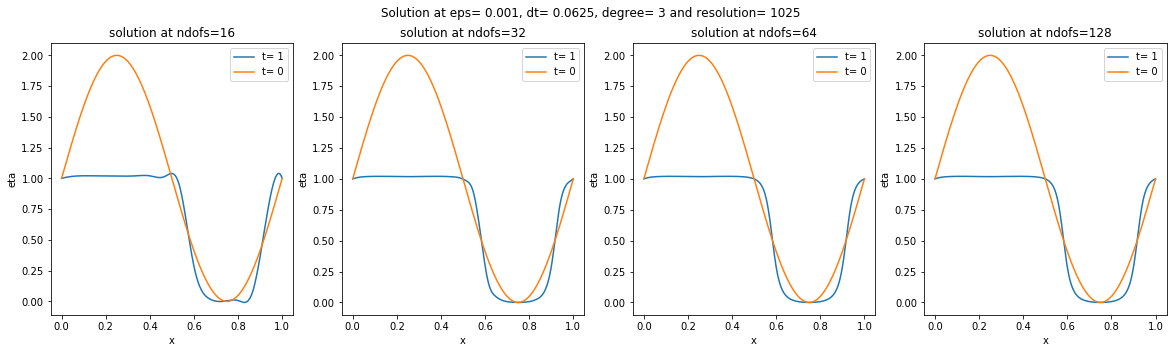

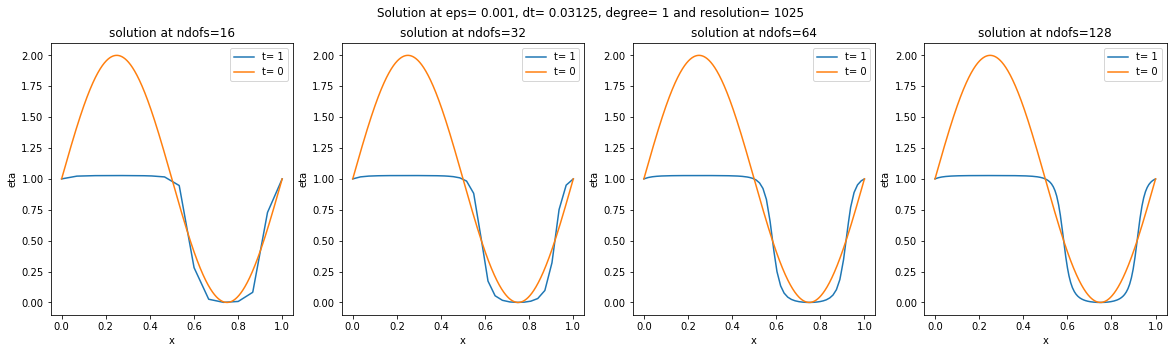

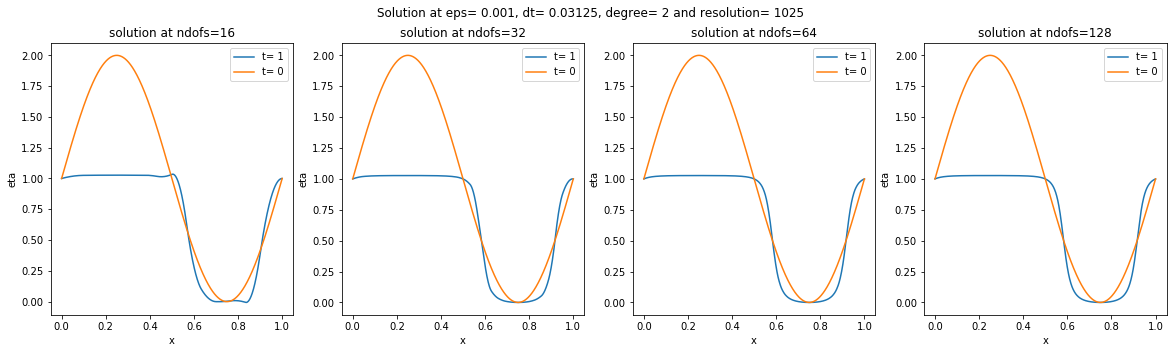

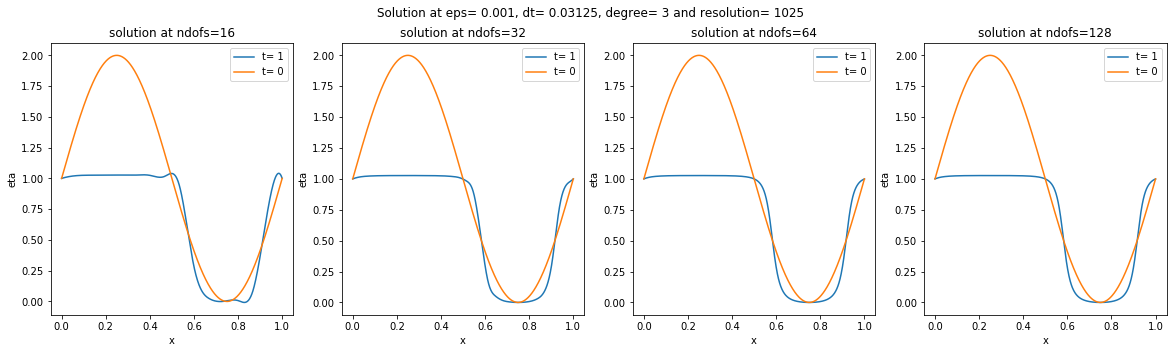

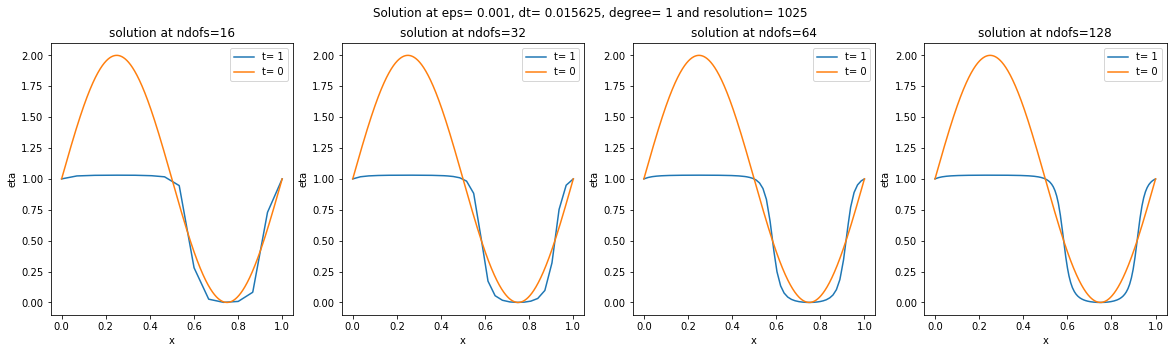

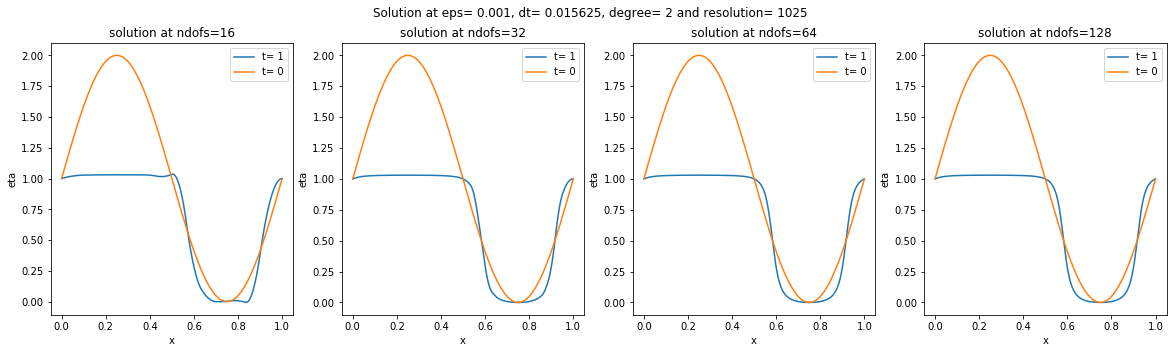

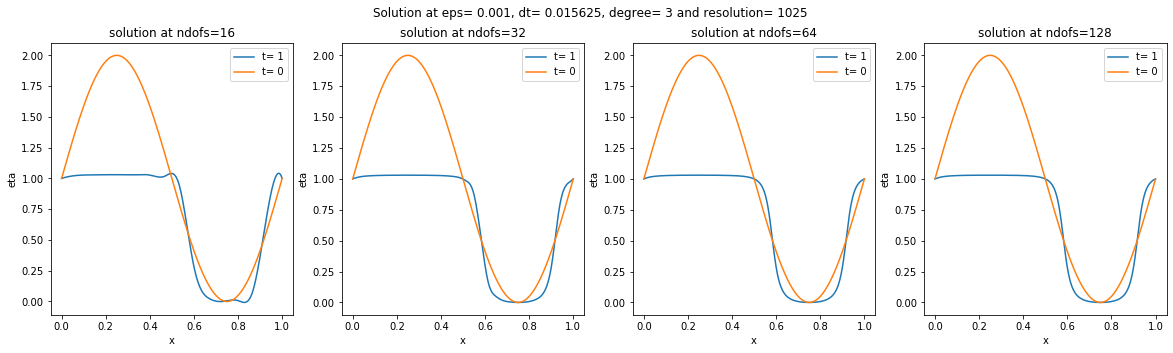

In [12]:
# Plots with eps = 0.001
for j in range(len(dt)):
    for k in range(len(degree)):
        plot_solution_at_one(eps[1], dt[j], ndofs, degree[k], resolution)

### Comment

The solution converges to the exact solution only if the  $\Delta t$ is small enough. This result is consistent with the method used, in fact the Forward Euler is conditionally stable, so there is a set of values for which the solution does not converge, in this case if the $\Delta t$ is large. By increasing the degree and the ndofs keepeng the dt constant we can observe that the function gets smoother.

# Step 4 (Optional)

Using a full Backward Euler method, which is uncoditionally stable the plots should show no instabilities even with a small time step $\Delta t$. The equation we have to solve now is the following:

\begin{equation}
((v_i , v_j) + \Delta t \epsilon ^2 (v_i ' , v_j '))\eta_{k+1}^j + \Delta t(v_i , \textit{f }'(\eta_{k+1}) )=(v_i, v_j)\eta_k^j 
\end{equation}

and doing some computations we have:

\begin{equation}
(v_i , v_j)( \eta_{k+1}^j + \Delta t \textit{f }' (\eta_{k+1}^j)) + \Delta t \epsilon ^2 (v_i ' , v_j ') \eta_{k+1}^j - (v_i , v_j)\eta_{k}^j = 0
\end{equation}

In [13]:
# Solve Backward Euler
def solve_back(eta_0_function, eps, dt, ndofs, degree):
    
    k = 1/dt + 1                                             # +1 to calculate in T=1
    eta = zeros((int(k), ndofs))                             # result matrix 
    q = linspace(0,1, ndofs)                                 # points for the computation
    
    b, db = compute_basis_functions(q, degree)
    gq, gw = compute_global_quadrature(b, degree+1)
    M, K = compute_system_matrices(b, db, gq, gw)
    
    eta_zero = eta_0_function(q)
    eta[0,:] = eta_zero                                      # fill the first row with eta zero
    eta_prev = eta_zero
    
    for i in range(1, (int(k))):                             # scipy.optipize.newton uses the Newton-Raphson method 
                                                             # to compute the zero in the function given some
                                                             # parameters and the max number of iterations
                                                             # fsolve: Return the roots of the (non-linear) equations defined by func(x) = 0 given a starting estimate.
        #eta_next = scipy.optimize.newton(lambda x : M.dot(x + dt*F(x)) + (dt*eps**2)*K.dot(x) - M.dot(eta_prev), eta_prev, maxiter = 500)
        eta_next= scipy.optimize.fsolve(lambda x : M.dot(x + dt*F(x)) + (dt*eps**2)*K.dot(x) - M.dot(eta_prev), eta_prev)
        eta[i,:] = eta_next
        eta_prev = eta_next
    
    return eta, b

In [14]:
# Plot the solution
def plot_back(eps, dt, ndofs_list, degree, res):
    x = linspace(0,1, res)

    y = eta0(x)
    
    fig, axs =plt.subplots(1,4, figsize=(20,5))                        # 4 plots per row
    fig.suptitle('Solution at eps= ' +str(eps)+ ', dt= ' +str(dt)+', degree= '+str(degree)+ ' and resolution= ' +str(res))
    for j in range(len(ndofs_list)):        
        eta, b = solve_back(eta0, eps, dt, ndofs_list[j], degree)
        B=zeros((resolution, len(b)))
        for i in range(len(b)):
            B[:,i] = b[i](x)
        (axs[j]).plot(x, eta[-1].dot(B.T))
        (axs[j]).plot(x,y)
        (axs[j]).set_title('solution at ndofs=' +str(ndofs[j]))
        (axs[j]).set(xlabel='x', ylabel='eta')

        (axs[j]).legend( ['t= 1', 't= 0'])

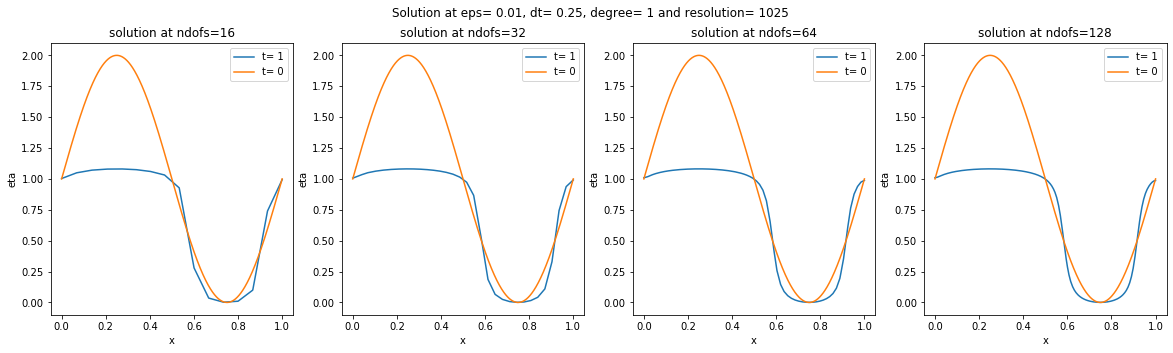

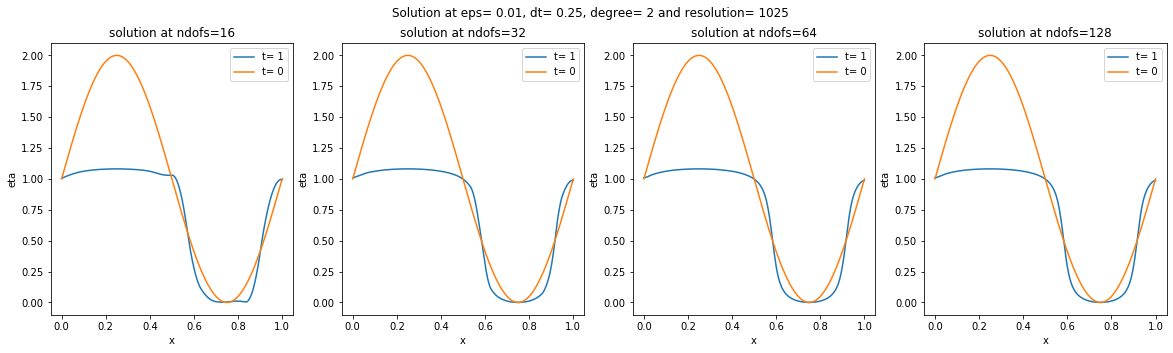

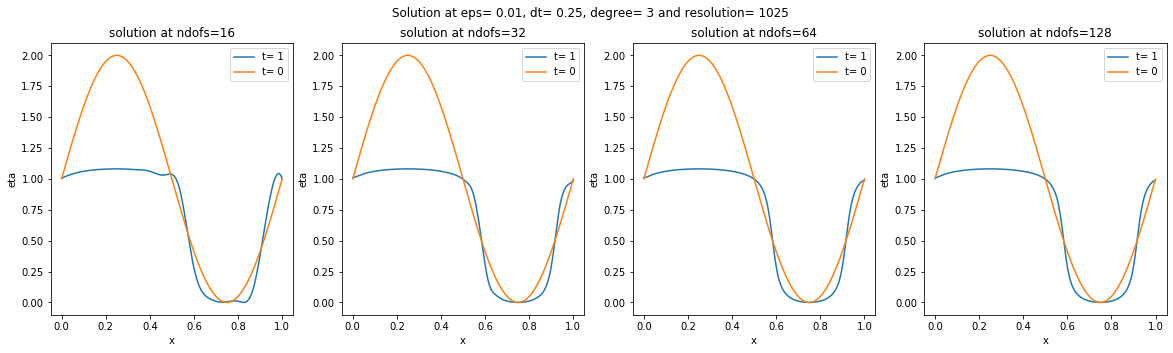

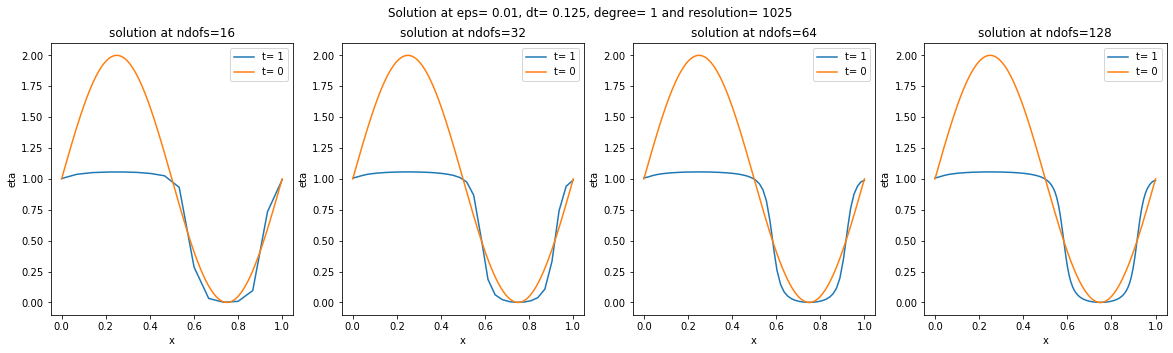

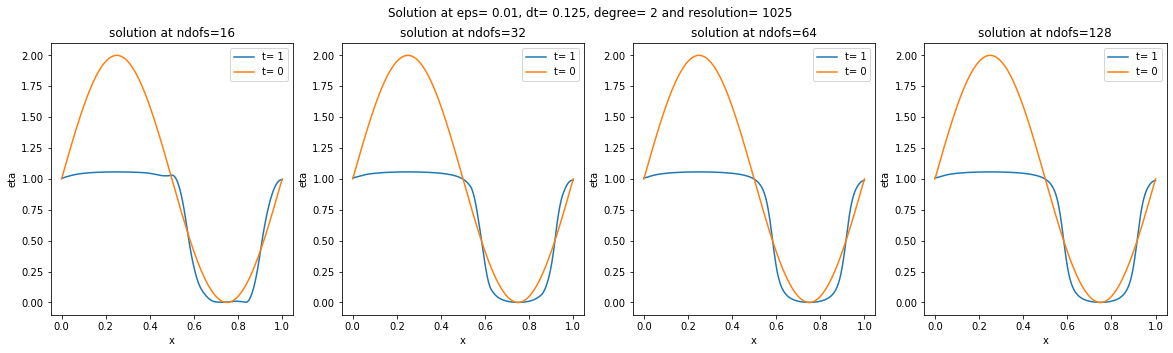

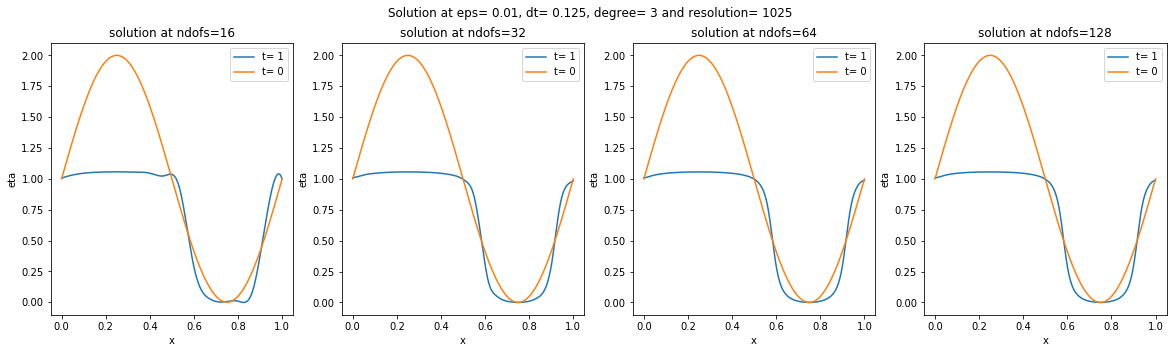

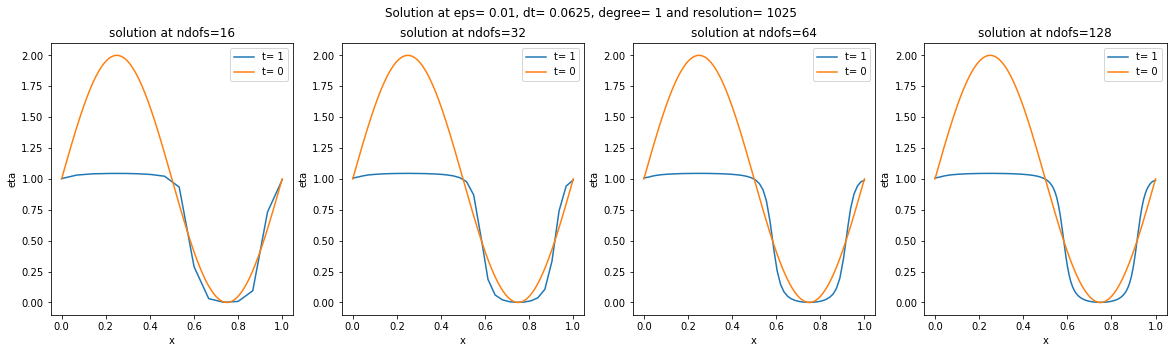

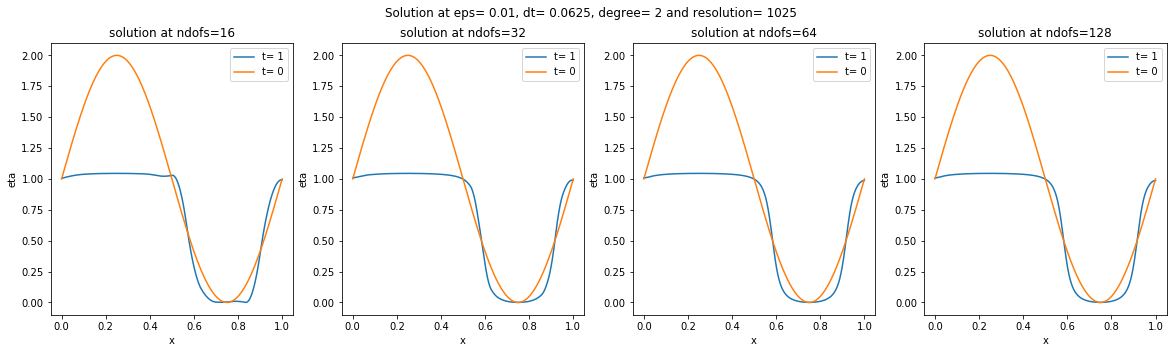

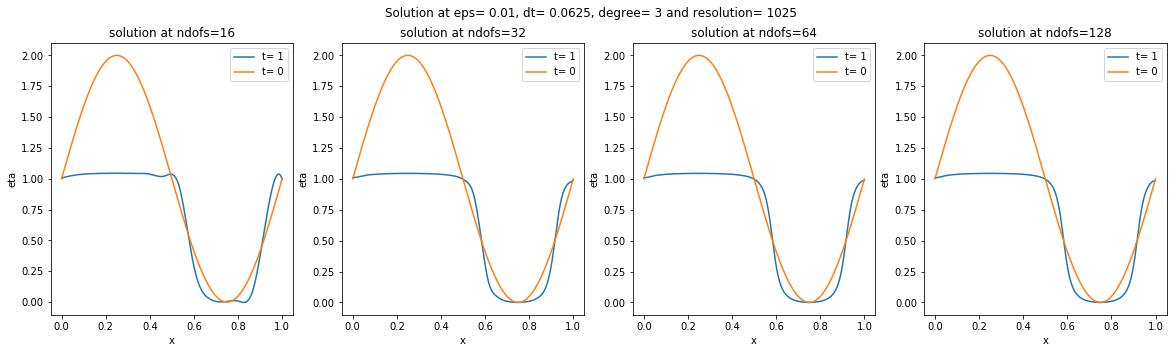

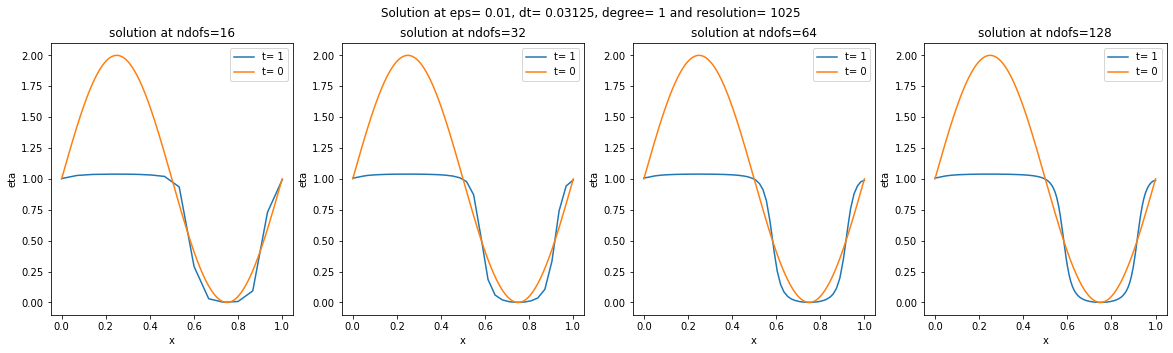

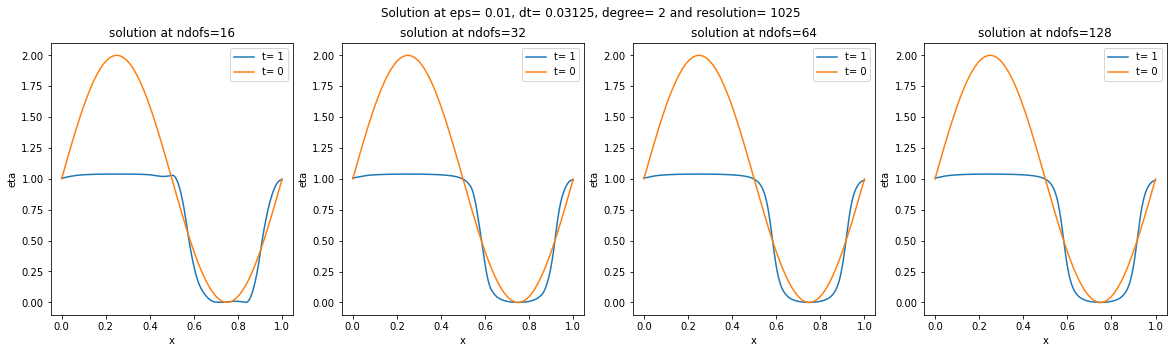

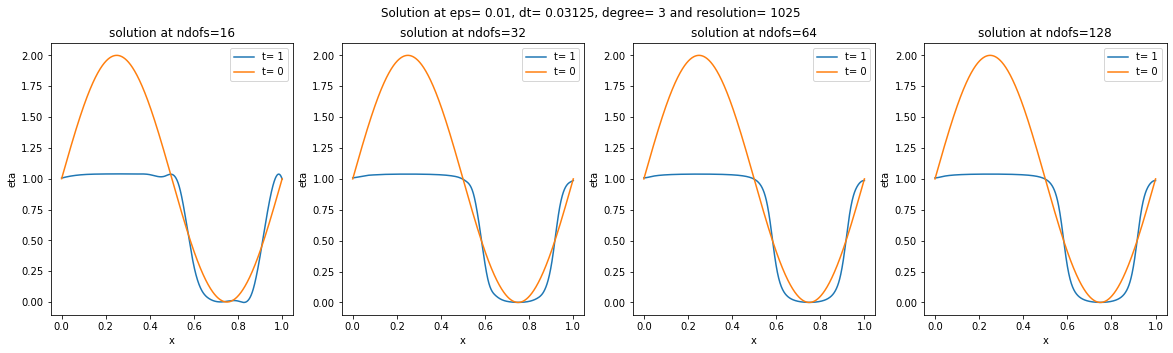

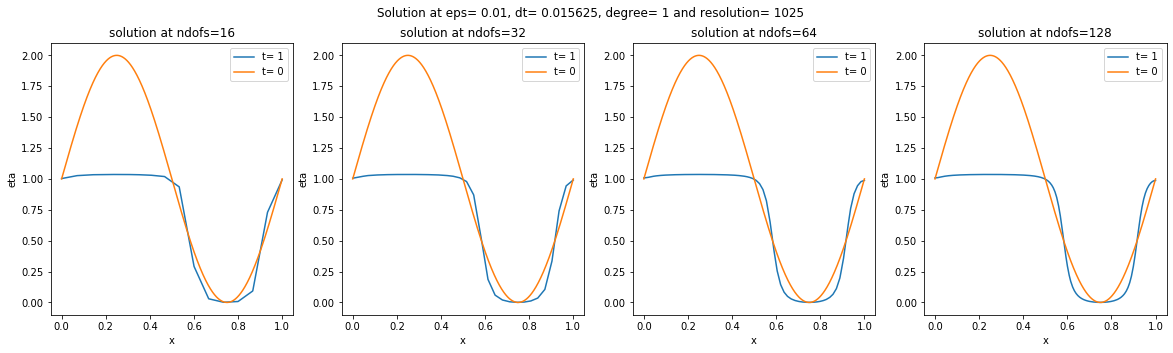

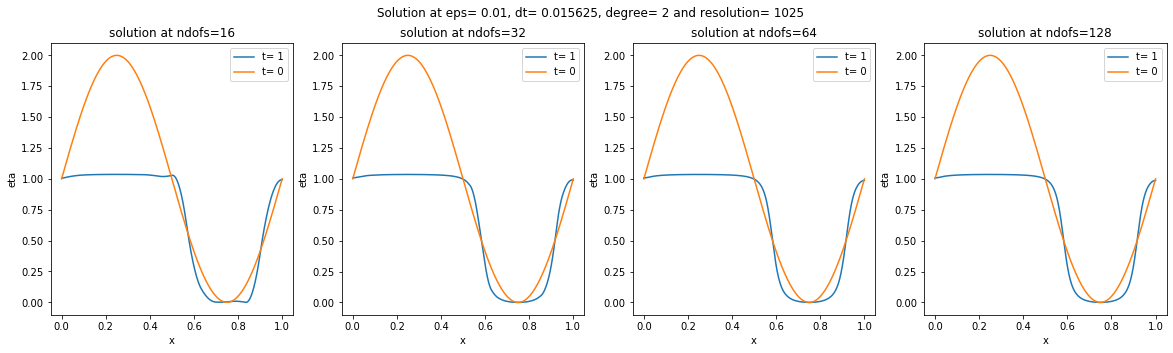

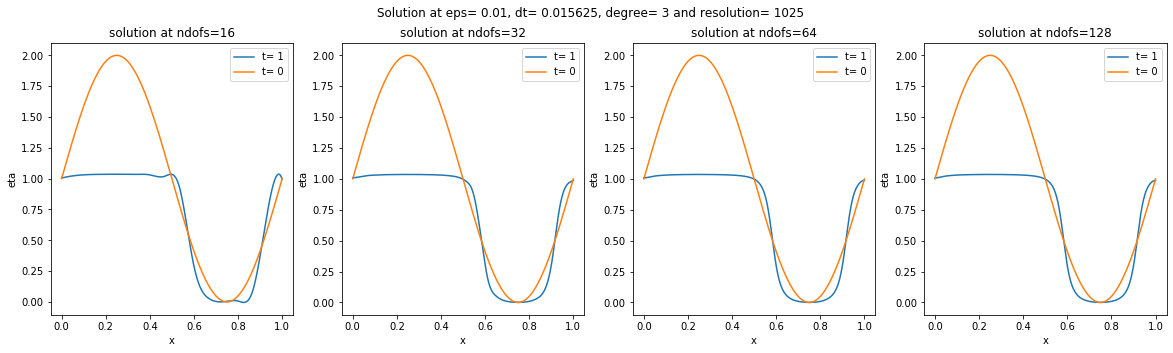

In [15]:
resolution=1025
#for i in range(len(eps))
for j in range(len(dt)):
    for k in range(len(degree)):
        plot_back(eps[0], dt[j], ndofs, degree[k], resolution)

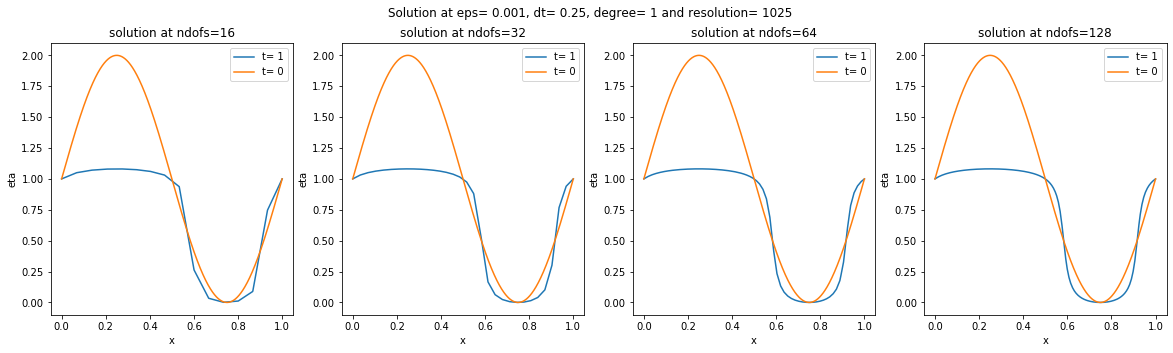

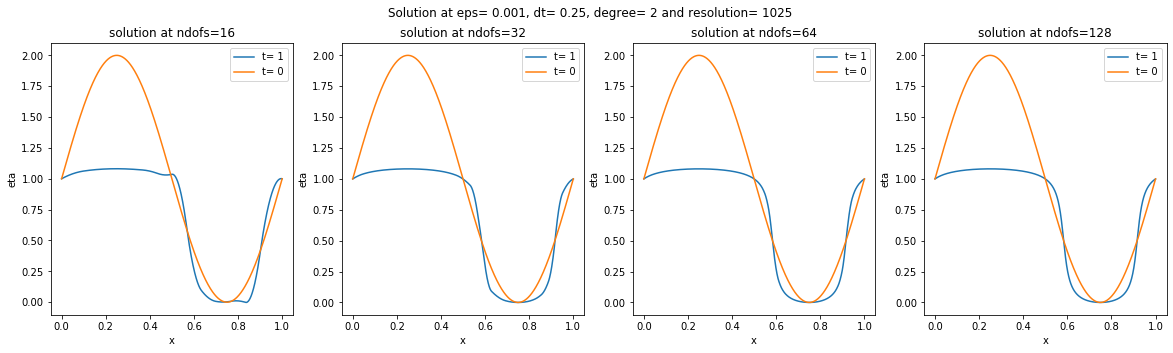

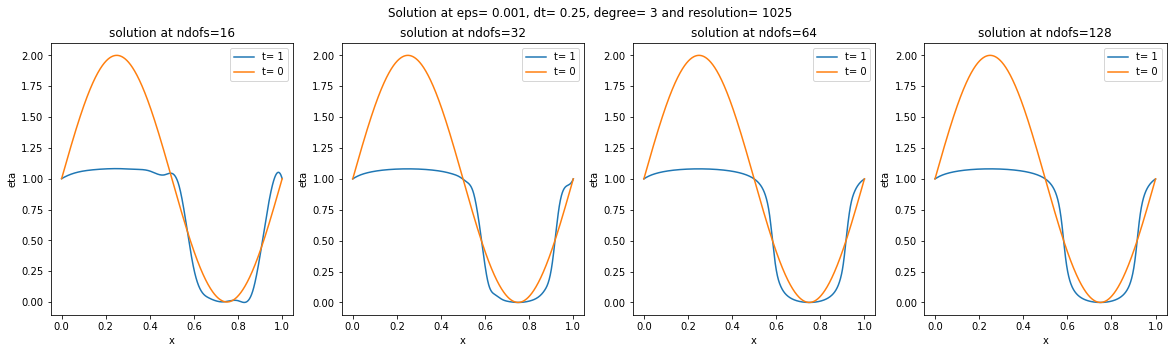

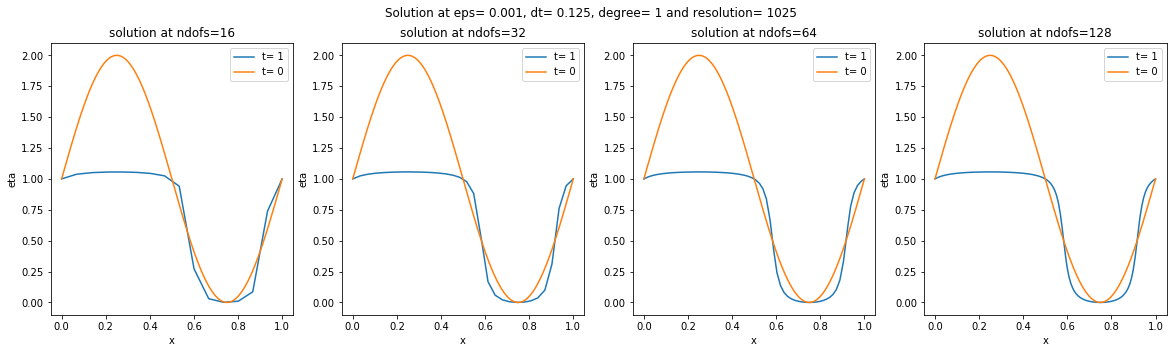

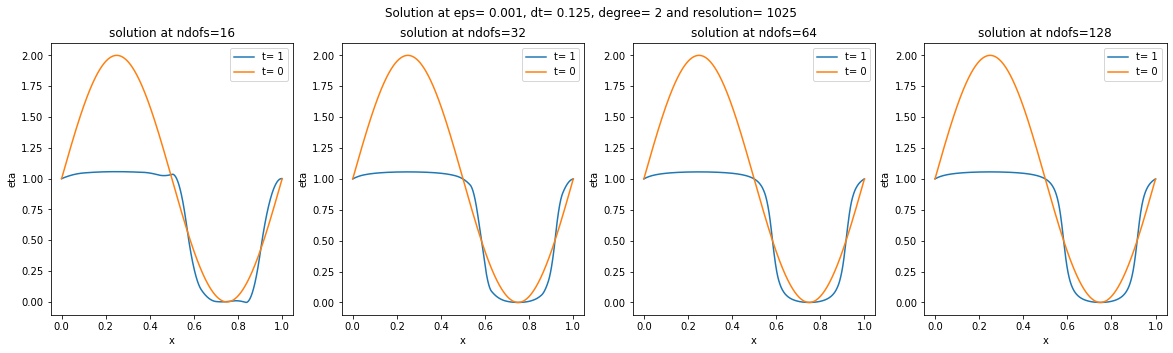

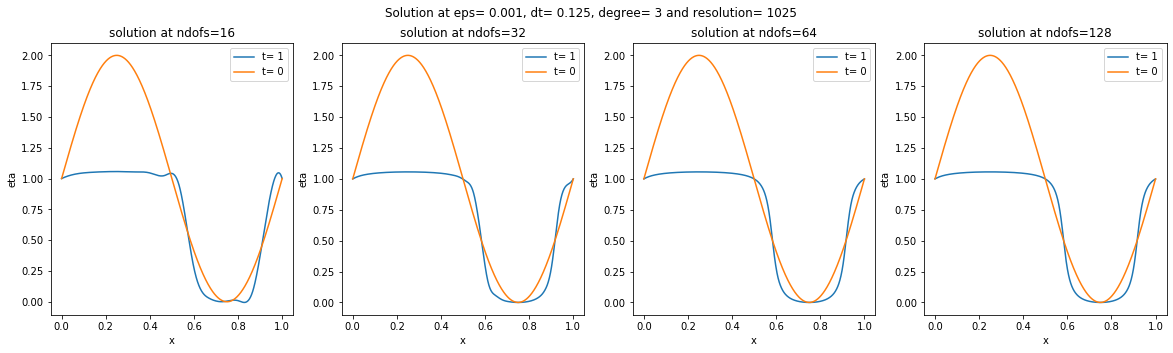

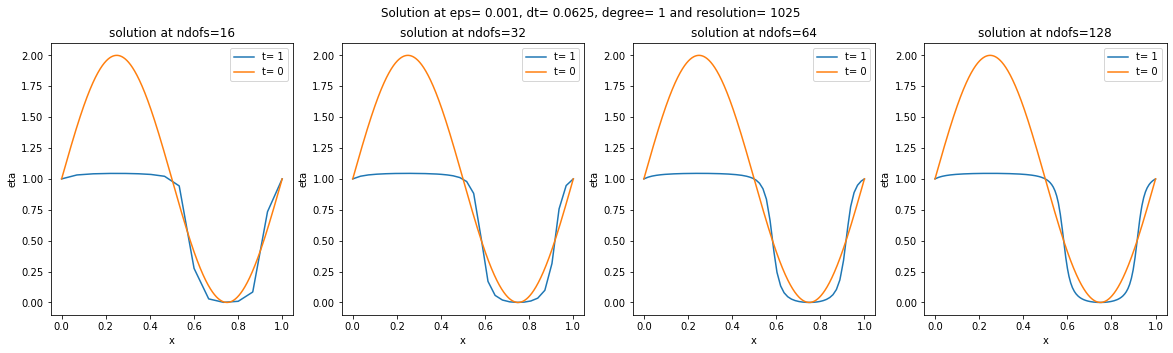

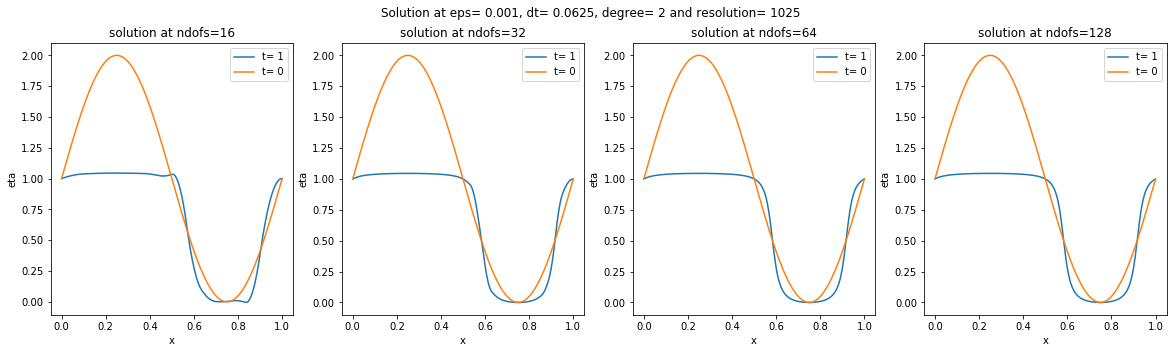

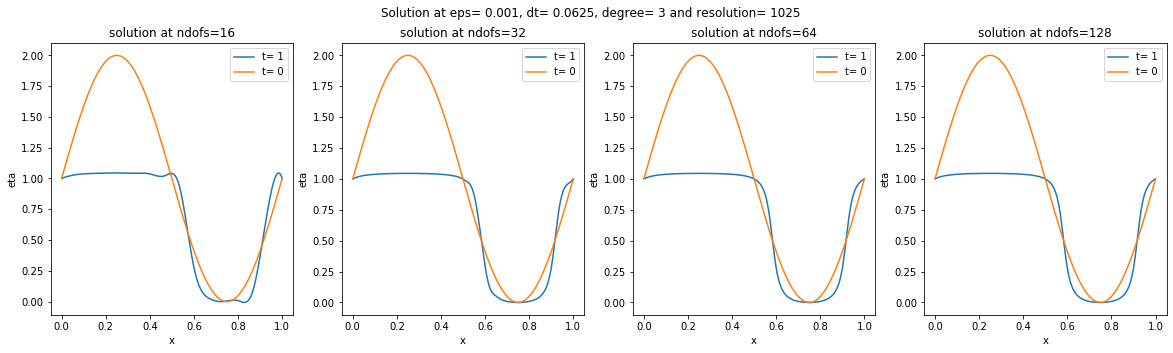

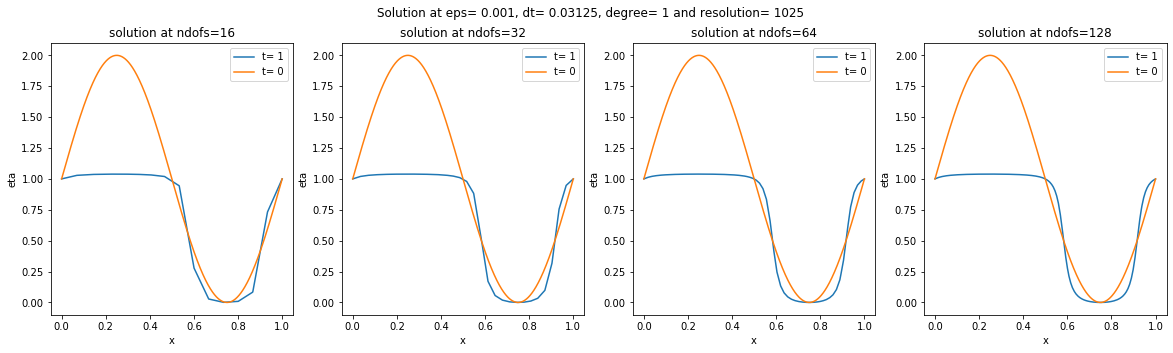

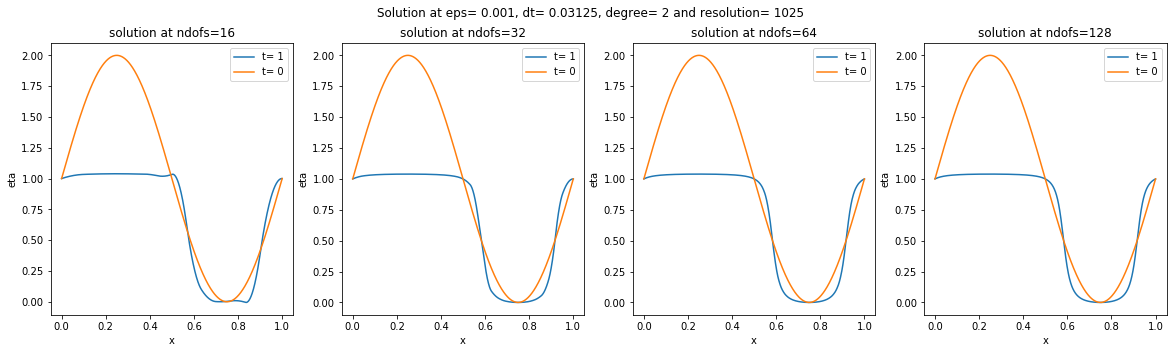

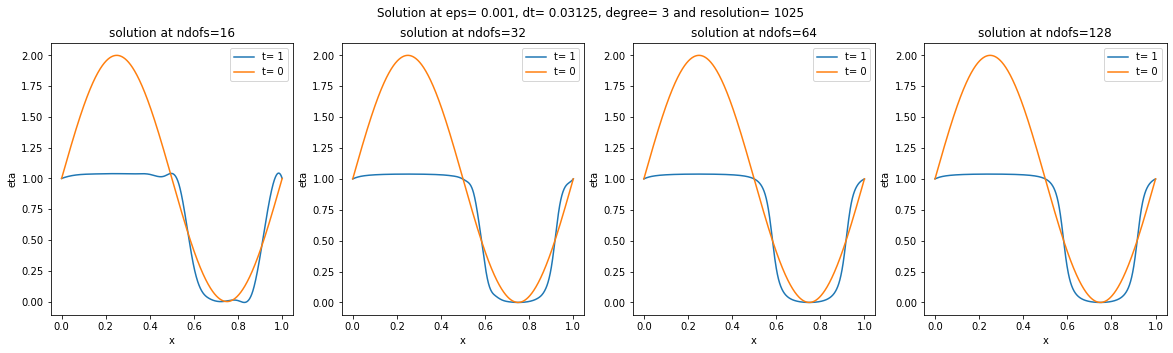

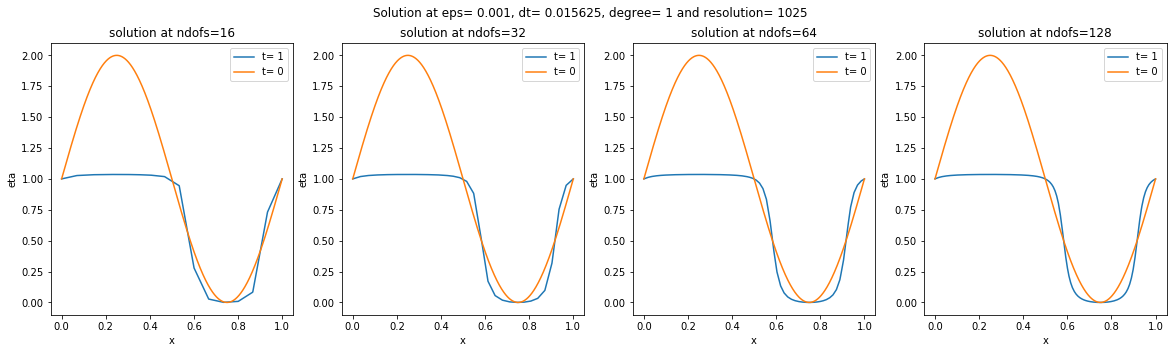

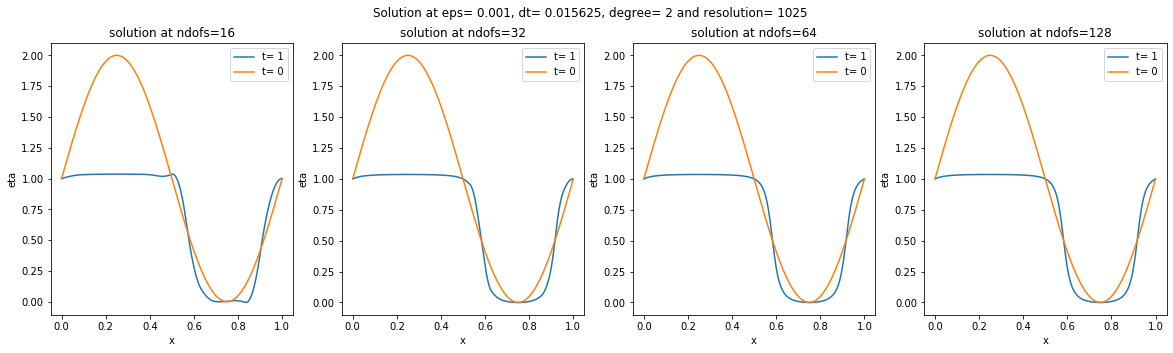

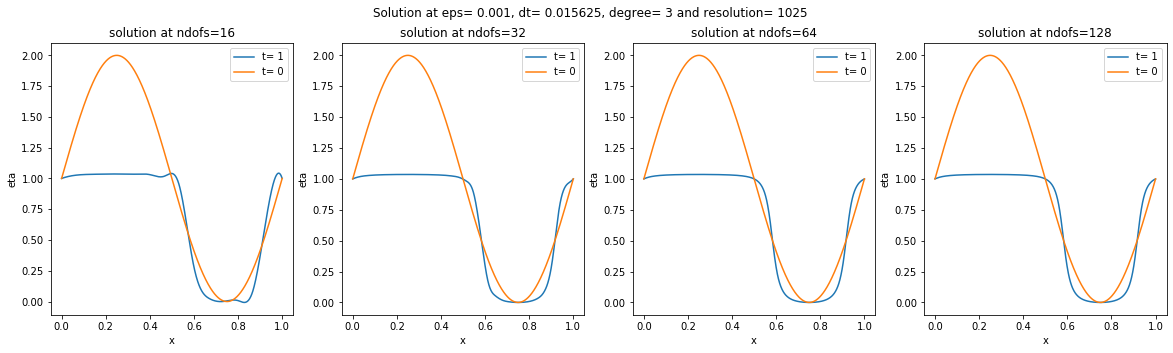

In [16]:
for j in range(len(dt)):
    for k in range(len(degree)):
        plot_back(eps[1], dt[j], ndofs, degree[k], resolution)

As we can see the results are consistent  with our expectations, even with a large $\Delta t$ we have that the solutions converge.